In [2]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/home/chris/miniconda3/envs/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

/home/chris/miniconda3/envs/env/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/home/chris/miniconda3/envs/env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found
Loading pipeline compone

In [4]:
from tqdm import tqdm
import os
path = 'data/raw/Train'
tiles = {}
for tile in tqdm(os.listdir(path)):
    DNB_files = []
    L2A_files = []
    LC08_files = []
    S1A_files = []
    gt_files = []
    for file in os.listdir(os.path.join(path,tile)):
        if file.startswith("DNB"):
            DNB_files.append(file)
        elif file.startswith("L2A"):
            L2A_files.append(file)
        elif file.startswith("LC08"):
            LC08_files.append(file)
        elif file.startswith("S1A"):
            S1A_files.append(file)
        else:
            gt_files.append(file)
    DNB_files.sort()
    L2A_files.sort()
    LC08_files.sort()
    S1A_files.sort()
    gt_files.sort()
    for i in range(len(DNB_files)):
        img = cv2.imread(os.path.join(path, tile, DNB_files[i]),cv2.IMREAD_UNCHANGED)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        DNB_files[i] = img
    for i in range(len(L2A_files)):
        img = cv2.imread(os.path.join(path, tile, L2A_files[i]),cv2.IMREAD_UNCHANGED)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        L2A_files[i] = img
    for i in range(len(LC08_files)):
        img = cv2.imread(os.path.join(path, tile, LC08_files[i]),cv2.IMREAD_UNCHANGED)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        LC08_files[i] = img
    for i in range(len(S1A_files)):
        img = cv2.imread(os.path.join(path, tile, S1A_files[i]),cv2.IMREAD_UNCHANGED)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        S1A_files[i] = img
    for i in range(len(gt_files)):
        img = cv2.imread(os.path.join(path, tile, gt_files[i]),cv2.IMREAD_UNCHANGED)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        gt_files[i] = img
    file_dict = {
        "DNB":DNB_files,
        "L2A": L2A_files,
        "LC08": LC08_files,
        "S1A" : S1A_files,
        "GT": gt_files
    }
    tiles[tile] = file_dict

100%|██████████| 60/60 [00:10<00:00,  5.76it/s]


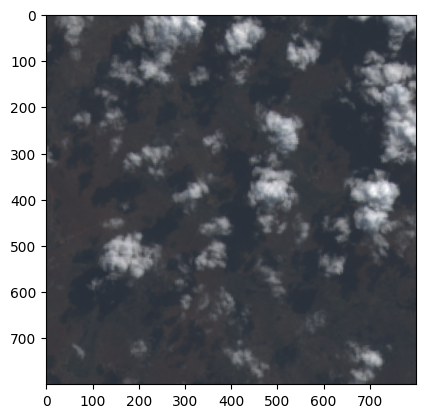

In [5]:
img = np.stack((tiles["Tile" + str(49)]["LC08"][5], tiles["Tile" + str(49)]["LC08"][4], tiles["Tile" + str(49)]["LC08"][3]), axis=2)
plt.imshow(img)

Target image size: 786432


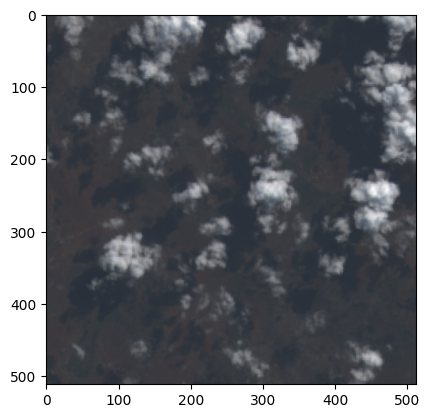

In [6]:
target_width, target_height = 512,512 # if you have memory issues, reduce even more the target size
source_image = img

# We make the image square
# source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

# We resize the image to the target dimensions (so that it uses less memory)
source_image = cv2.resize(source_image, (target_width, target_height), interpolation=cv2.INTER_AREA)
print(f"Target image size: {source_image.size}")

### we convert the image into an array in order to use it later with the segmentation model
segmentation_image = asarray(source_image)

plt.imshow(source_image)

In [7]:
### Initialize Segment Anything Model

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

### Pay attention to the pred_iou_thresh, the lower the more masks it will generate. Make it higher to generate masks only of 
### good quality and less number of them
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [8]:
### Run Segmentation Model
masks = mask_generator.generate(segmentation_image)

### Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

# Intersection Over Union (IoU) tell us the degree of overlap between two boxes. 
# In the case of object detection and segmentation, it refers to the overlap of the Ground Truth and Prediction region

Number of masks generated: 64
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

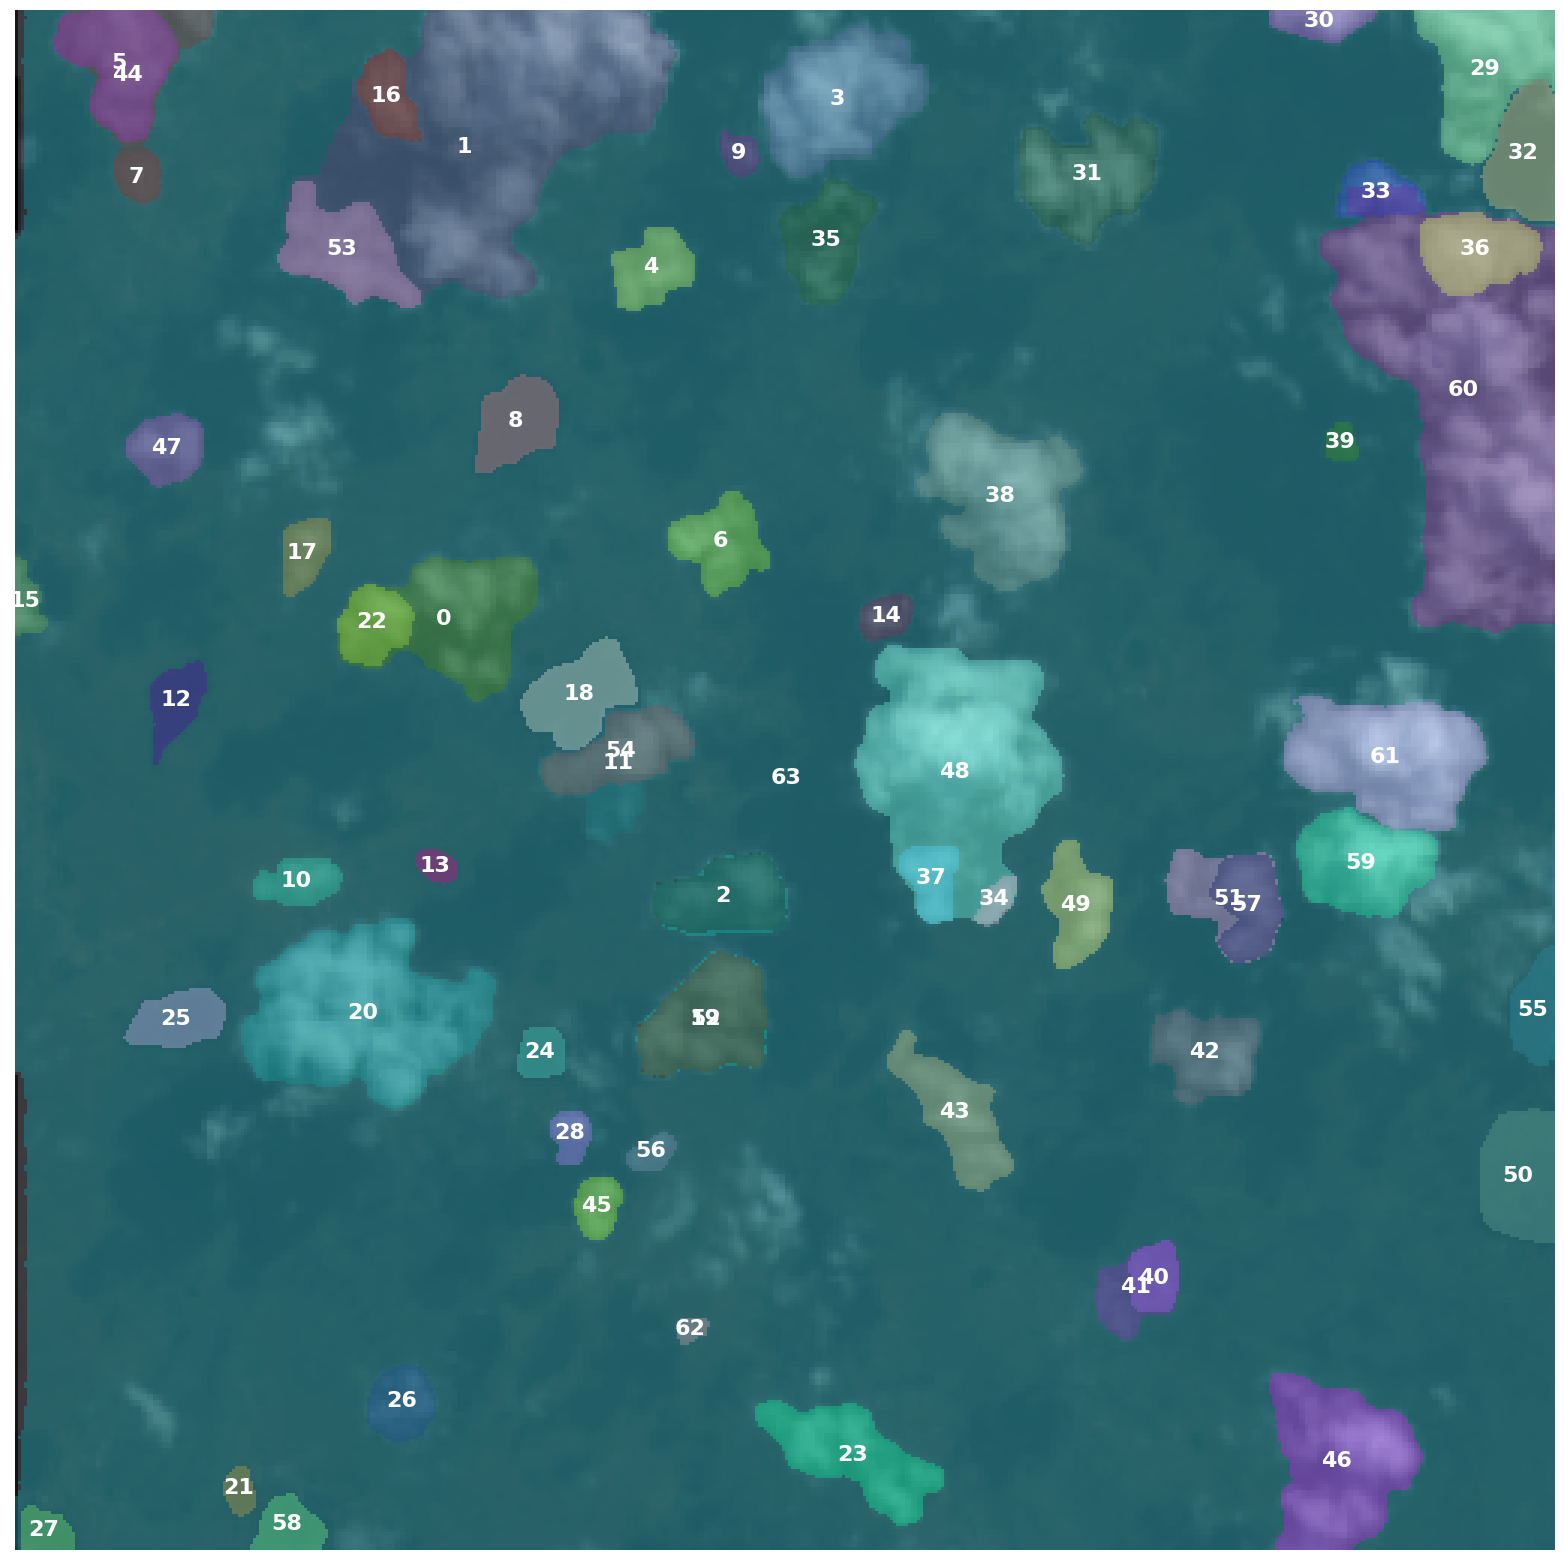

In [12]:
### Display Masks with a number identifying each of them

plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show() 

In [35]:
### Explore one of the keys of the mask
for i, values in enumerate(masks):
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")

# IoU: 0 means no overlap and 1 means perfect overlap

0: Area: 3069 | IoU: 0.9825516939163208
1: Area: 4380 | IoU: 0.9798147678375244
2: Area: 9344 | IoU: 0.9790886044502258
3: Area: 1200 | IoU: 0.9778264760971069
4: Area: 920 | IoU: 0.9606146812438965
5: Area: 184 | IoU: 0.9596933722496033
6: Area: 1681 | IoU: 0.955739438533783
7: Area: 243 | IoU: 0.9555543661117554
8: Area: 154 | IoU: 0.9517858028411865
9: Area: 404 | IoU: 0.9508916735649109
10: Area: 5002 | IoU: 1.0093690156936646
11: Area: 1787 | IoU: 0.9878422021865845
12: Area: 1298 | IoU: 0.9646173715591431
13: Area: 327 | IoU: 0.9553912878036499
14: Area: 180 | IoU: 0.9550091028213501
15: Area: 870 | IoU: 0.9535926580429077
16: Area: 20635 | IoU: 0.993911862373352
17: Area: 424 | IoU: 0.992845356464386
18: Area: 6039 | IoU: 0.9702568054199219
19: Area: 362 | IoU: 0.9689765572547913
20: Area: 6925 | IoU: 0.9620991945266724
21: Area: 510 | IoU: 0.9576064348220825
22: Area: 3635 | IoU: 0.9791332483291626
23: Area: 482 | IoU: 0.9713150262832642
24: Area: 476 | IoU: 0.9587774872779846


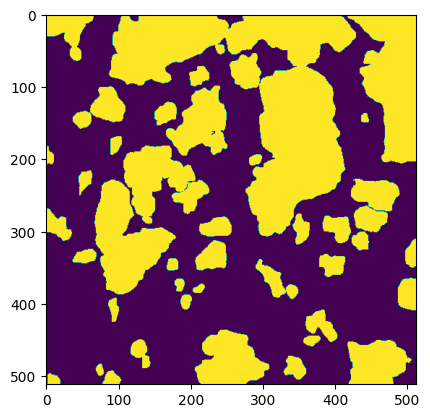

In [65]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 4
mask_index = 30
for i in range(62):
    segmentation_mask += masks[i]['segmentation']
# segmentation_mask=masks[mask_index]['segmentation']
# stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
stable_diffusion_mask = segmentation_mask.astype(np.uint8)
# display(stable_diffusion_mask)
plt.imshow(stable_diffusion_mask)

In [68]:
### Setup transformation prompts
num_images_per_prompt = 4
# inpainting_prompts = ["",  "", "", ""]
inpainting_prompts = ["landscape"]
generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77, 

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(len(inpainting_prompts)):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

100%|██████████| 60/60 [00:03<00:00, 19.54it/s]


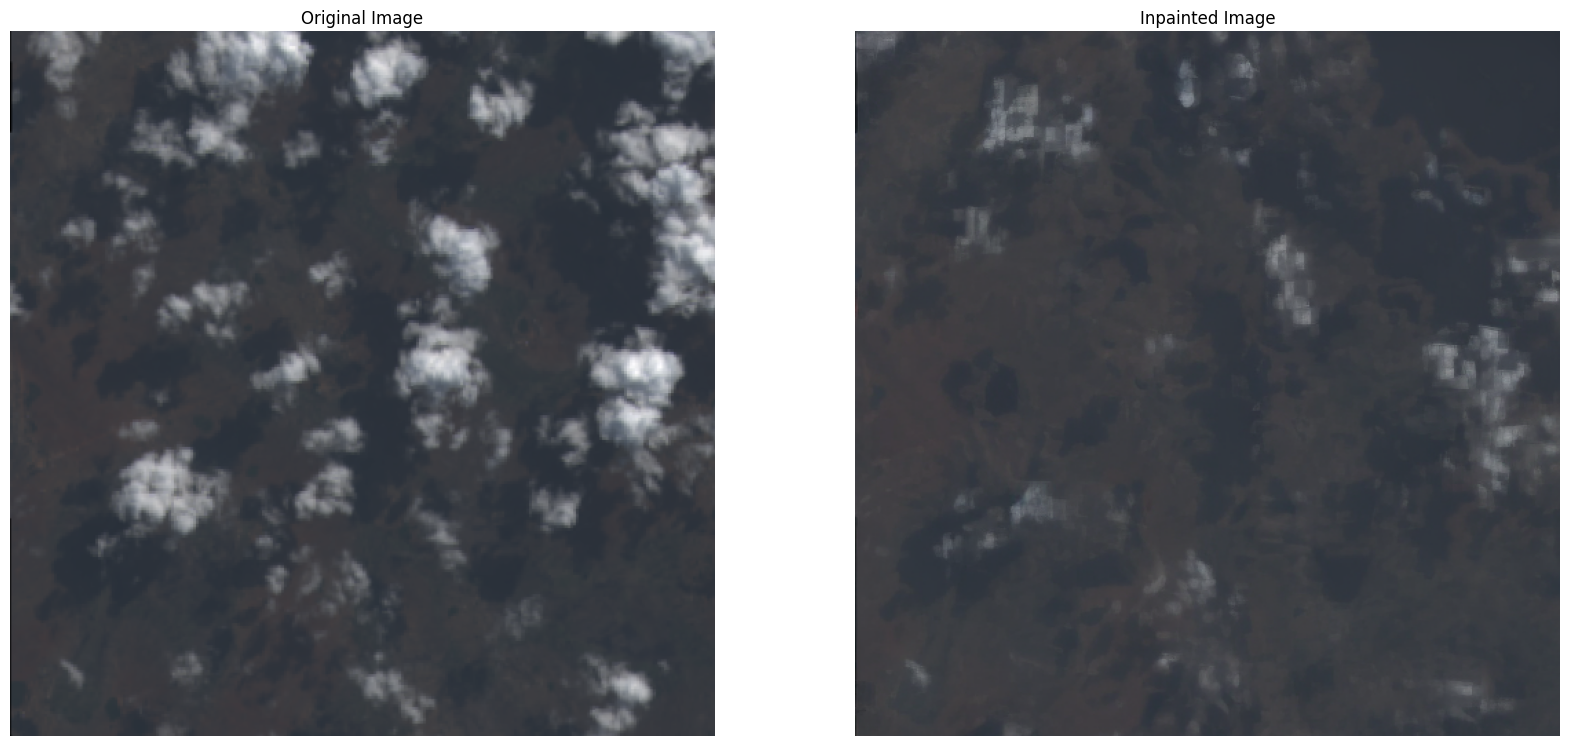

In [71]:

def show_single_image(image, name=""):
    # Check if the image is a tensor
    if torch.is_tensor(image):
        # Convert tensor image to PIL image and apply sigmoid normalization
        image = to_pil_image(torch.sigmoid(image))

    # Create a figure
    fig, ax = plt.subplots(1, 2, figsize=(20, 15))
    ax[0].imshow(source_image)
    ax[0].axis('off')
    ax[0].set_title("Original Image")
    # Add the image to the subplot
    ax[1].imshow(image, cmap='gray' if torch.is_tensor(image) else None)

    # Set the title (name) for the subplot
    ax[1].set_title(name)

    # Turn off axes for the subplot
    ax[1].axis('off')
    
    
    # Display the image
    plt.show()

show_single_image(encoded_images[0], "Inpainted Image")

In [58]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


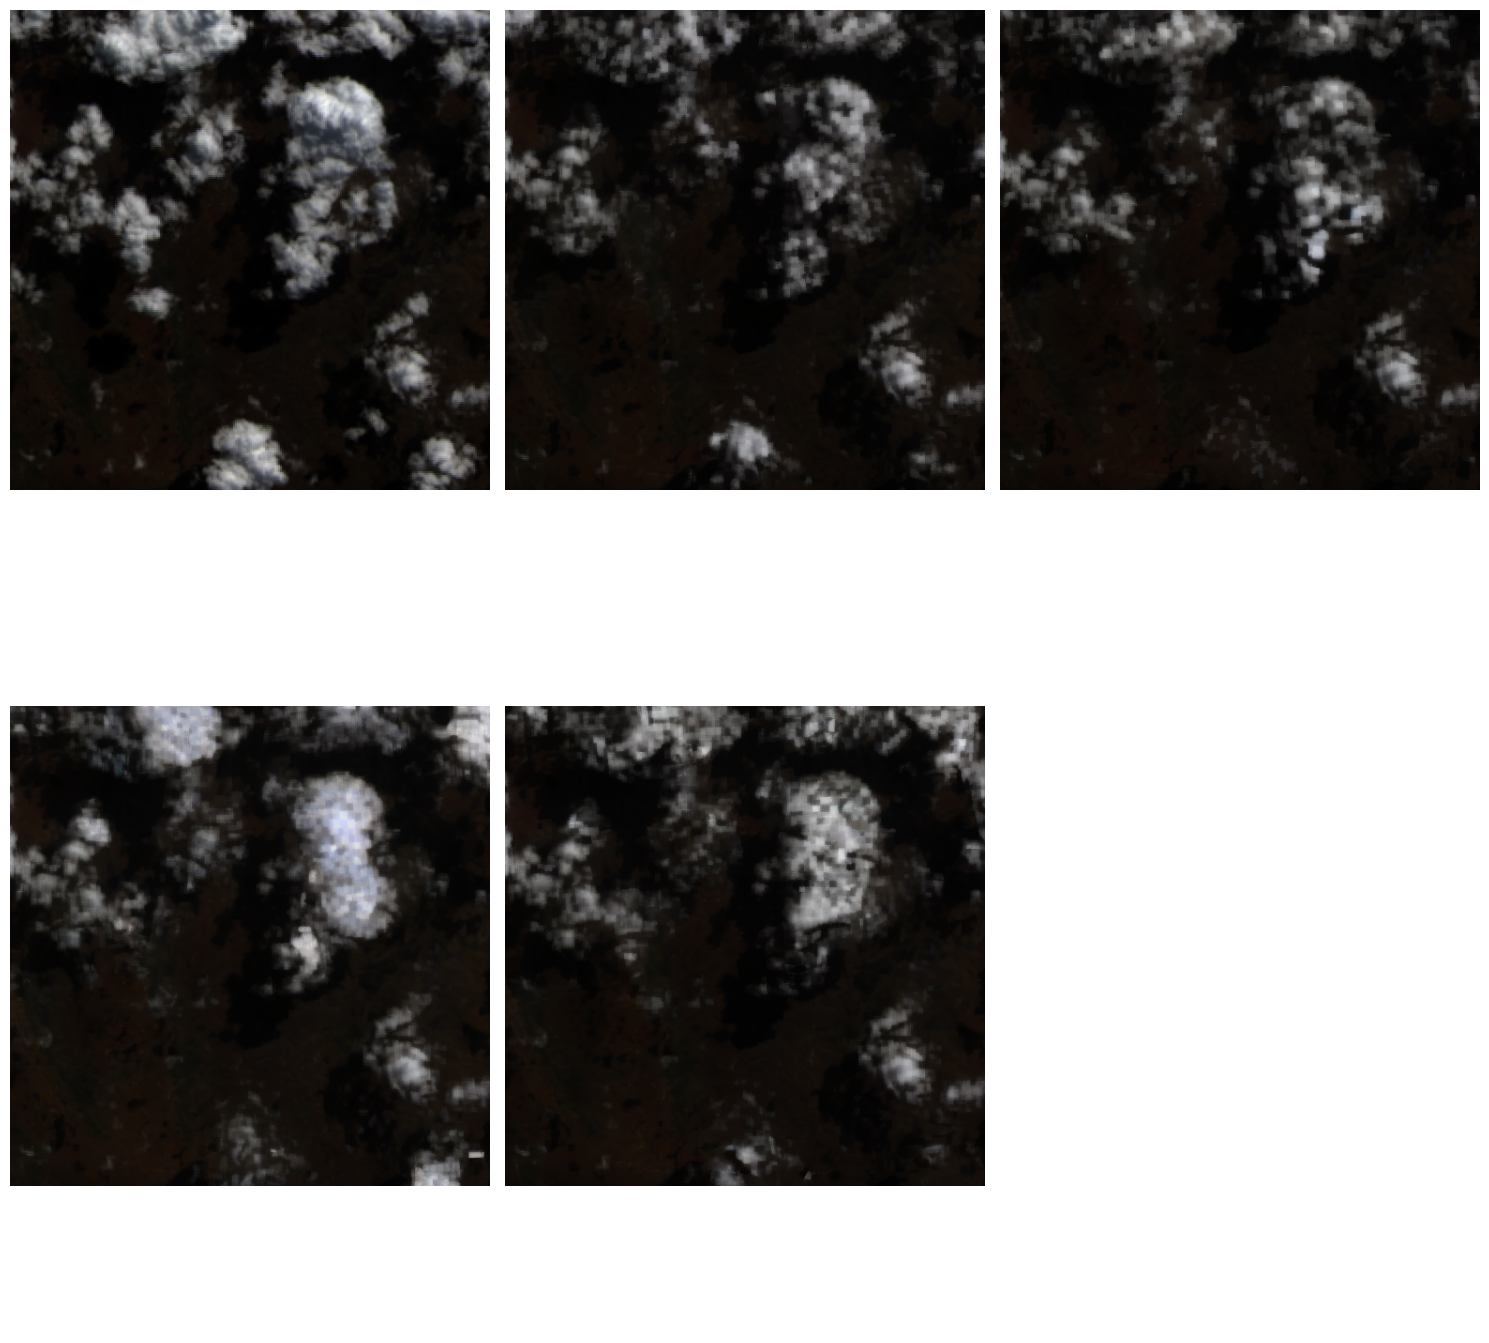

In [59]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)